In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import LSTM, SimpleRNN, Dropout, GRU, Conv1D, MaxPool1D
from tensorflow.keras.callbacks import LambdaCallback, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, Nadam


%load_ext autoreload
%autoreload 2

In [10]:
class TimeSeriesData():


    def __init__(self):
        self.file_dict = {'FluDataSet': [r'../../Data/flusearches.csv', 'flu'], 'AirlineSales': [r'../../Data/international-airline-passengers.csv', 'passengers'], 'SinData': [r'Data/sin.csv','sin'], 'FemaleBirth':[r'../../Data/daily-total-female-births.csv','Births']}
        print('List of data sources:')
        for item in self.file_dict.keys():
            print('\t{}'.format(item))

    def load_data(self, source_name, normalize=True):
        import pandas as pd
        from matplotlib import pyplot as plt
        """read a CSV into a dataframe"""

        self.source_name = source_name

        if self.source_name in self.file_dict.keys():
            df = pd.read_csv(self.file_dict[self.source_name][0])
            self.data = df[self.file_dict[self.source_name][1]].astype('float32').values
        else:
            raise ValueError('The source name was not found')
            self.__init__()
        if normalize:
            max_val = max(self.data)
            min_val = min(self.data)
            self.data = (self.data-min_val)/(max_val-min_val)
        fig, ax = plt.subplots(1,1, figsize = (8,5))
        ax.plot(self.data)
        ax.grid()
        ax.set_title('{}'.format(self.source_name))



    def create_sequential_data(self, look_back, train_portion=0.7):
        """convert an array of values into a data matrix
            A data sequence of selected length(i.e look_back) will be set as the training data
            and the next number is the label
        """
        split = int(len(self.data) * 0.70)
        train = self.data[:split]
        # test = data[split-look_back-2:]
        test = self.data[split-look_back:]

        dataX_train, dataY_train = [], []

        # for i in range(len(dataset)-look_back-1):
        for i in range(len(train)-look_back):
            a = train[i:(i+look_back)]
            dataX_train.append(a)
            dataY_train.append(train[i + look_back])

        dataX_test, dataY_test = [], []
        # for i in range(len(dataset)-look_back-1):
        for i in range(len(test)-look_back):
            a = test[i:(i+look_back)]
            dataX_test.append(a)
            dataY_test.append(test[i + look_back])

        return np.array(dataX_train), np.array(dataY_train), np.array(dataX_test), np.array(dataY_test)


# Load data

In [11]:
time_data = TimeSeriesData()

List of data sources:
	FluDataSet
	AirlineSales
	SinData
	FemaleBirth


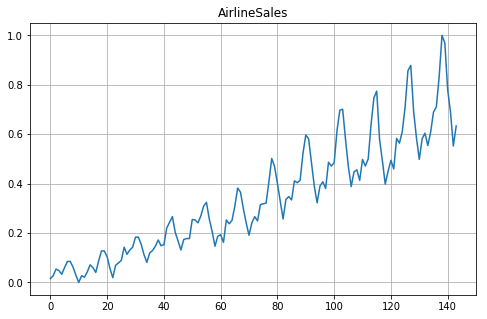

In [12]:
time_data.load_data('AirlineSales', normalize=True)

# Using simple linear regression

Relying on classic linear regression based on covariance between the response and missing variables.

In [13]:
X, y = range(len(time_data.data)), time_data.data

# Train and test data sets
split = int(len(X) * 0.70)

X_train,X_test = X[:split], X[split:]
y_train,y_test = y[:split], y[split:]

In [14]:
slope_math = np.cov(X_train,y_train)[0][1]/np.cov(X_train,y_train)[0][0] # Covariance(X,y)/Variance(X)
intercept_math = np.mean(y_train)-slope_math*np.mean(X_train) # mean(y) - slope * mean(X)

In [15]:
y_predicted = X * slope_math + intercept_math

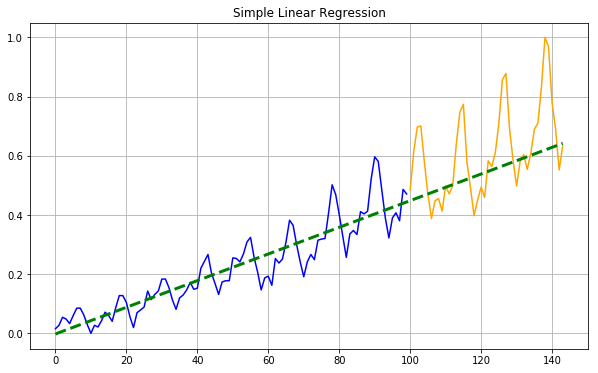

In [16]:
fig, ax = plt.subplots(1,1, figsize= (10,6))
ax.plot(X_train,y_train,'b')
ax.plot(X_test,y_test,'orange')
ax.plot(X,y_predicted,'g', lw=3,ls='--')
ax.set_title('Simple Linear Regression')
ax.grid()

# Using Neural Network

Neural networks are robust to noise in input data and can be trained even in presence of missing values. Also, there is no strong assumption about the linearity of the mapping function between the input and output. Thus neural networks can learn/approximate linear and non-linear relationships 

"... One important contribution of neural networks namely their ability to approximate arbitrary non-linear functions. This property is of high value in time series processing and promises more powerful applications ..."

__Georg Dorffner, Neural Network for Time Series Processing, 1996


## Helper functions and classes

In [17]:
class Config():
    def __init__(self, batch_size, look_back, n_epochs, train_portion, min_delta, stop_patience, lr_patience=None, rnn_nodes = None, repeated_predictions=False, monitor ='loss'):    
        self.repeated_predictions = repeated_predictions
        self.batch_size = batch_size
        self.rnn_nodes = rnn_nodes
        self.look_back = look_back
        self.n_epochs = n_epochs
        self.train_portion = train_portion
        
        # Early stop call back for keras
        self.early_stop_clbk = tf.keras.callbacks.EarlyStopping(monitor='loss', 
                                                                min_delta=min_delta, 
                                                                patience=stop_patience,
                                                                verbose=0, 
                                                                mode='auto',
                                                                restore_best_weights=True)
        if lr_patience is not None:
            # Adaptive learning rate call back for keras
            self.lr_plan = ReduceLROnPlateau(monitor='val_loss',
                                             factor=0.1,patience=lr_patience,
                                             verbose=0,
                                             mode='auto',
                                             min_delta=min_delta)
            
def plot_model_results(model):
    fig, main_ax = plt.subplots(1,2, figsize= (16,5))

    ax = main_ax[0]
    ax.plot(history.history['loss'], label='Loss')
    ax.plot(history.history['val_loss'], label='Validation Loss')
    ax.grid()
    ax.legend()

    ax = main_ax[1]
    preds_test = model.predict(testX)
    preds_train = model.predict(trainX)
    ax.plot(trainY, label='Training Value')
    ax.plot(preds_train, label='Training Prediction')
    ax.plot(np.append(np.empty_like(trainY) * np.nan, testY), label='Test Value')
    ax.plot(np.append(np.empty_like(trainY) * np.nan, preds_test), label = 'Test Prediction')
    ax.legend()
    ax.grid()

## Using Multi Layer Perceptron (MLP) Netwroks

Feed-forward networks are widely used for time series prediction.

In [18]:
config = Config(batch_size=50, look_back=15, n_epochs = 2000, train_portion = 0.7, min_delta=0.001, stop_patience=200)

### Sliding Window Transformation

Using sliding window transformation to transform time series data into supervised learning format i.e. input and output.

[1,2,3,4,5,6,7,8,...]

  &ensp;&ensp;X&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;Y
  
[1,2,3]&ensp;&ensp;&ensp;&ensp;[4]

[2,3,4]&ensp;&ensp;&ensp;&ensp;[5]

[3,4,5]&ensp;&ensp;&ensp;&ensp;[6]

...

The number of look back defines how many data records in the past will be included in the training data set to inform the next data record as the label

In [19]:
trainX, trainY, testX, testY = time_data.create_sequential_data(look_back=config.look_back,
                                                                train_portion=config.train_portion)

In [20]:
model = Sequential(name='MLPSequential')

model.add(Dense(32, input_shape=(config.look_back,), activation="relu",name='Dense1')) 

model.add(Dropout(0.1))

model.add(Dense(1, activation="linear", name='Output'))

model.compile(loss='mae', optimizer=Adam(0.001))

model.summary()

Model: "MLPSequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense1 (Dense)               (None, 32)                512       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
Output (Dense)               (None, 1)                 33        
Total params: 545
Trainable params: 545
Non-trainable params: 0
_________________________________________________________________


In [21]:
history = model.fit(trainX, trainY, epochs=config.n_epochs, 
                    batch_size=config.batch_size, 
                    validation_data=(testX, testY), 
                    callbacks=[config.early_stop_clbk])

Train on 85 samples, validate on 44 samples
Epoch 1/2000
85/85 [==============================] - 0s 6ms/sample - loss: 0.1020 - val_loss: 0.1506
Epoch 2/2000
85/85 [==============================] - 0s 259us/sample - loss: 0.0797 - val_loss: 0.1540
Epoch 3/2000
85/85 [==============================] - 0s 165us/sample - loss: 0.0723 - val_loss: 0.1649
Epoch 4/2000
85/85 [==============================] - 0s 188us/sample - loss: 0.0783 - val_loss: 0.1707
Epoch 5/2000
85/85 [==============================] - 0s 177us/sample - loss: 0.0942 - val_loss: 0.1651
Epoch 6/2000
85/85 [==============================] - 0s 212us/sample - loss: 0.0779 - val_loss: 0.1561
Epoch 7/2000
85/85 [==============================] - 0s 177us/sample - loss: 0.0803 - val_loss: 0.1447
Epoch 8/2000
85/85 [==============================] - 0s 153us/sample - loss: 0.0823 - val_loss: 0.1319
Epoch 9/2000
85/85 [==============================] - 0s 165us/sample - loss: 0.0784 - val_loss: 0.1216
Epoch 10/2000
85/85 [=

85/85 [==============================] - 0s 129us/sample - loss: 0.0371 - val_loss: 0.0449
Epoch 79/2000
85/85 [==============================] - 0s 153us/sample - loss: 0.0381 - val_loss: 0.0421
Epoch 80/2000
85/85 [==============================] - 0s 130us/sample - loss: 0.0347 - val_loss: 0.0380
Epoch 81/2000
85/85 [==============================] - 0s 118us/sample - loss: 0.0373 - val_loss: 0.0357
Epoch 82/2000
85/85 [==============================] - 0s 141us/sample - loss: 0.0388 - val_loss: 0.0365
Epoch 83/2000
85/85 [==============================] - 0s 130us/sample - loss: 0.0364 - val_loss: 0.0354
Epoch 84/2000
85/85 [==============================] - 0s 129us/sample - loss: 0.0315 - val_loss: 0.0374
Epoch 85/2000
85/85 [==============================] - 0s 129us/sample - loss: 0.0347 - val_loss: 0.0381
Epoch 86/2000
85/85 [==============================] - 0s 118us/sample - loss: 0.0373 - val_loss: 0.0361
Epoch 87/2000
85/85 [==============================] - 0s 141us/sampl

85/85 [==============================] - 0s 153us/sample - loss: 0.0274 - val_loss: 0.0314
Epoch 156/2000
85/85 [==============================] - 0s 141us/sample - loss: 0.0296 - val_loss: 0.0323
Epoch 157/2000
85/85 [==============================] - 0s 129us/sample - loss: 0.0278 - val_loss: 0.0336
Epoch 158/2000
85/85 [==============================] - 0s 153us/sample - loss: 0.0251 - val_loss: 0.0328
Epoch 159/2000
85/85 [==============================] - 0s 141us/sample - loss: 0.0261 - val_loss: 0.0321
Epoch 160/2000
85/85 [==============================] - 0s 118us/sample - loss: 0.0257 - val_loss: 0.0326
Epoch 161/2000
85/85 [==============================] - 0s 141us/sample - loss: 0.0244 - val_loss: 0.0341
Epoch 162/2000
85/85 [==============================] - 0s 118us/sample - loss: 0.0293 - val_loss: 0.0322
Epoch 163/2000
85/85 [==============================] - 0s 141us/sample - loss: 0.0298 - val_loss: 0.0322
Epoch 164/2000
85/85 [==============================] - 0s 12

85/85 [==============================] - 0s 118us/sample - loss: 0.0241 - val_loss: 0.0296
Epoch 233/2000
85/85 [==============================] - 0s 129us/sample - loss: 0.0243 - val_loss: 0.0312
Epoch 234/2000
85/85 [==============================] - 0s 106us/sample - loss: 0.0225 - val_loss: 0.0304
Epoch 235/2000
85/85 [==============================] - 0s 129us/sample - loss: 0.0255 - val_loss: 0.0295
Epoch 236/2000
85/85 [==============================] - 0s 118us/sample - loss: 0.0238 - val_loss: 0.0282
Epoch 237/2000
85/85 [==============================] - 0s 106us/sample - loss: 0.0275 - val_loss: 0.0281
Epoch 238/2000
85/85 [==============================] - 0s 129us/sample - loss: 0.0227 - val_loss: 0.0279
Epoch 239/2000
85/85 [==============================] - 0s 106us/sample - loss: 0.0254 - val_loss: 0.0282
Epoch 240/2000
85/85 [==============================] - 0s 118us/sample - loss: 0.0243 - val_loss: 0.0318
Epoch 241/2000
85/85 [==============================] - 0s 14

85/85 [==============================] - 0s 141us/sample - loss: 0.0196 - val_loss: 0.0266
Epoch 310/2000
85/85 [==============================] - 0s 118us/sample - loss: 0.0222 - val_loss: 0.0271
Epoch 311/2000
85/85 [==============================] - 0s 130us/sample - loss: 0.0243 - val_loss: 0.0322
Epoch 312/2000
85/85 [==============================] - 0s 118us/sample - loss: 0.0205 - val_loss: 0.0353
Epoch 313/2000
85/85 [==============================] - 0s 118us/sample - loss: 0.0200 - val_loss: 0.0343
Epoch 314/2000
85/85 [==============================] - 0s 129us/sample - loss: 0.0236 - val_loss: 0.0339
Epoch 315/2000
85/85 [==============================] - 0s 118us/sample - loss: 0.0209 - val_loss: 0.0319
Epoch 316/2000
85/85 [==============================] - 0s 118us/sample - loss: 0.0212 - val_loss: 0.0304
Epoch 317/2000
85/85 [==============================] - 0s 129us/sample - loss: 0.0192 - val_loss: 0.0285
Epoch 318/2000
85/85 [==============================] - 0s 12

85/85 [==============================] - 0s 118us/sample - loss: 0.0205 - val_loss: 0.0353
Epoch 387/2000
85/85 [==============================] - 0s 129us/sample - loss: 0.0198 - val_loss: 0.0311
Epoch 388/2000
85/85 [==============================] - 0s 118us/sample - loss: 0.0187 - val_loss: 0.0294
Epoch 389/2000
85/85 [==============================] - 0s 141us/sample - loss: 0.0225 - val_loss: 0.0318
Epoch 390/2000
85/85 [==============================] - 0s 118us/sample - loss: 0.0208 - val_loss: 0.0315
Epoch 391/2000
85/85 [==============================] - 0s 118us/sample - loss: 0.0198 - val_loss: 0.0310
Epoch 392/2000
85/85 [==============================] - 0s 106us/sample - loss: 0.0225 - val_loss: 0.0326
Epoch 393/2000
85/85 [==============================] - 0s 141us/sample - loss: 0.0203 - val_loss: 0.0334
Epoch 394/2000
85/85 [==============================] - 0s 118us/sample - loss: 0.0227 - val_loss: 0.0294
Epoch 395/2000
85/85 [==============================] - 0s 11

85/85 [==============================] - 0s 129us/sample - loss: 0.0182 - val_loss: 0.0418
Epoch 464/2000
85/85 [==============================] - 0s 118us/sample - loss: 0.0193 - val_loss: 0.0396
Epoch 465/2000
85/85 [==============================] - 0s 130us/sample - loss: 0.0208 - val_loss: 0.0377
Epoch 466/2000
85/85 [==============================] - 0s 118us/sample - loss: 0.0221 - val_loss: 0.0362
Epoch 467/2000
85/85 [==============================] - 0s 118us/sample - loss: 0.0189 - val_loss: 0.0349
Epoch 468/2000
85/85 [==============================] - 0s 129us/sample - loss: 0.0241 - val_loss: 0.0332
Epoch 469/2000
85/85 [==============================] - 0s 129us/sample - loss: 0.0179 - val_loss: 0.0357
Epoch 470/2000
85/85 [==============================] - 0s 141us/sample - loss: 0.0223 - val_loss: 0.0383
Epoch 471/2000
85/85 [==============================] - 0s 118us/sample - loss: 0.0221 - val_loss: 0.0400
Epoch 472/2000
85/85 [==============================] - 0s 11

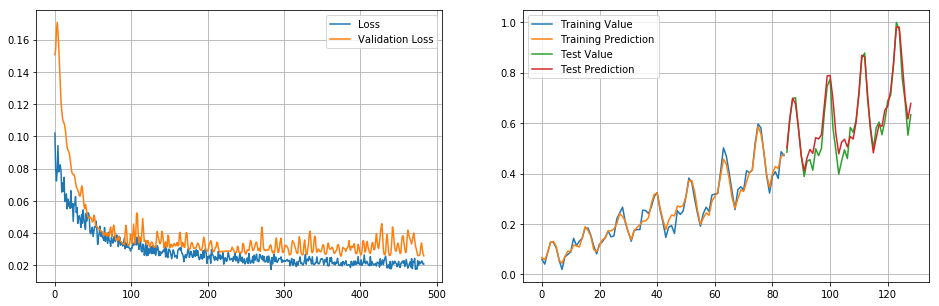

In [22]:
plot_model_results(model)

## Using CNN

using convolutional neural networks

In [23]:
# Central configuration
config = Config(batch_size=50, look_back=20, n_epochs = 2000, train_portion = 0.7, min_delta=0.001, stop_patience=200)

In [24]:
trainX, trainY, testX, testY = time_data.create_sequential_data(look_back=config.look_back,
                                                                train_portion=config.train_portion)

# Add channel dimension
trainX = trainX[:, :, np.newaxis] # n_observations, n_sequence, n_features
testX = testX[:, :, np.newaxis]

In [25]:
# create and fit the RNN
model = Sequential(name='CnnSequential')

model.add(Conv1D(32, 2, input_shape=(config.look_back, 1), activation='relu', padding='same', name='Conv1D')) # the size of the output layer is always rrn_nodes no matter using LSTM or RNN or GRU

model.add(MaxPool1D(pool_size = 2, padding='same', name='MaxPool1D'))

model.add(Flatten(name='Flatten'))

model.add(Dense(50, activation='relu', name='Dense'))

model.add(Dense(1, activation='linear', name='Output'))

model.compile(loss='mse', optimizer=Nadam(learning_rate=0.001))

model.summary()

Model: "CnnSequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1D (Conv1D)              (None, 20, 32)            96        
_________________________________________________________________
MaxPool1D (MaxPooling1D)     (None, 10, 32)            0         
_________________________________________________________________
Flatten (Flatten)            (None, 320)               0         
_________________________________________________________________
Dense (Dense)                (None, 50)                16050     
_________________________________________________________________
Output (Dense)               (None, 1)                 51        
Total params: 16,197
Trainable params: 16,197
Non-trainable params: 0
_________________________________________________________________


In [26]:
history = model.fit(trainX, trainY, epochs=config.n_epochs, 
                    batch_size=config.batch_size, 
                    validation_data=(testX, testY), 
                    callbacks=[config.early_stop_clbk])

Train on 80 samples, validate on 44 samples
Epoch 1/2000
80/80 [==============================] - 1s 9ms/sample - loss: 0.0879 - val_loss: 0.2125
Epoch 2/2000
80/80 [==============================] - 0s 200us/sample - loss: 0.0394 - val_loss: 0.0931
Epoch 3/2000
80/80 [==============================] - 0s 187us/sample - loss: 0.0164 - val_loss: 0.0334
Epoch 4/2000
80/80 [==============================] - 0s 188us/sample - loss: 0.0056 - val_loss: 0.0128
Epoch 5/2000
80/80 [==============================] - 0s 225us/sample - loss: 0.0029 - val_loss: 0.0102
Epoch 6/2000
80/80 [==============================] - 0s 188us/sample - loss: 0.0032 - val_loss: 0.0102
Epoch 7/2000
80/80 [==============================] - 0s 200us/sample - loss: 0.0030 - val_loss: 0.0103
Epoch 8/2000
80/80 [==============================] - 0s 213us/sample - loss: 0.0031 - val_loss: 0.0100
Epoch 9/2000
80/80 [==============================] - 0s 225us/sample - loss: 0.0029 - val_loss: 0.0094
Epoch 10/2000
80/80 [=

80/80 [==============================] - 0s 187us/sample - loss: 6.0861e-04 - val_loss: 0.0024
Epoch 78/2000
80/80 [==============================] - 0s 163us/sample - loss: 6.0177e-04 - val_loss: 0.0018
Epoch 79/2000
80/80 [==============================] - 0s 225us/sample - loss: 5.9774e-04 - val_loss: 0.0016
Epoch 80/2000
80/80 [==============================] - 0s 213us/sample - loss: 6.1847e-04 - val_loss: 0.0017
Epoch 81/2000
80/80 [==============================] - 0s 238us/sample - loss: 5.8312e-04 - val_loss: 0.0027
Epoch 82/2000
80/80 [==============================] - 0s 225us/sample - loss: 6.0516e-04 - val_loss: 0.0020
Epoch 83/2000
80/80 [==============================] - 0s 212us/sample - loss: 5.5770e-04 - val_loss: 0.0019
Epoch 84/2000
80/80 [==============================] - 0s 200us/sample - loss: 5.5088e-04 - val_loss: 0.0018
Epoch 85/2000
80/80 [==============================] - 0s 200us/sample - loss: 5.7101e-04 - val_loss: 0.0017
Epoch 86/2000
80/80 [============

Epoch 152/2000
80/80 [==============================] - 0s 200us/sample - loss: 4.8176e-04 - val_loss: 0.0014
Epoch 153/2000
80/80 [==============================] - 0s 162us/sample - loss: 5.3526e-04 - val_loss: 0.0017
Epoch 154/2000
80/80 [==============================] - 0s 200us/sample - loss: 4.0046e-04 - val_loss: 0.0027
Epoch 155/2000
80/80 [==============================] - 0s 163us/sample - loss: 4.0808e-04 - val_loss: 0.0015
Epoch 156/2000
80/80 [==============================] - 0s 150us/sample - loss: 3.4972e-04 - val_loss: 0.0013
Epoch 157/2000
80/80 [==============================] - 0s 187us/sample - loss: 3.7208e-04 - val_loss: 0.0014
Epoch 158/2000
80/80 [==============================] - 0s 188us/sample - loss: 3.4150e-04 - val_loss: 0.0025
Epoch 159/2000
80/80 [==============================] - 0s 187us/sample - loss: 3.7253e-04 - val_loss: 0.0014
Epoch 160/2000
80/80 [==============================] - 0s 162us/sample - loss: 3.4333e-04 - val_loss: 0.0013
Epoch 161/

80/80 [==============================] - 0s 162us/sample - loss: 2.7125e-04 - val_loss: 0.0012
Epoch 227/2000
80/80 [==============================] - 0s 200us/sample - loss: 3.1541e-04 - val_loss: 0.0015
Epoch 228/2000
80/80 [==============================] - 0s 163us/sample - loss: 4.8282e-04 - val_loss: 0.0015
Epoch 229/2000
80/80 [==============================] - 0s 187us/sample - loss: 4.4330e-04 - val_loss: 0.0014
Epoch 230/2000
80/80 [==============================] - 0s 162us/sample - loss: 4.4811e-04 - val_loss: 0.0012
Epoch 231/2000
80/80 [==============================] - 0s 187us/sample - loss: 4.1822e-04 - val_loss: 0.0017
Epoch 232/2000
80/80 [==============================] - 0s 200us/sample - loss: 5.3971e-04 - val_loss: 0.0012
Epoch 233/2000
80/80 [==============================] - 0s 212us/sample - loss: 3.1980e-04 - val_loss: 0.0012
Epoch 234/2000
80/80 [==============================] - 0s 200us/sample - loss: 2.6449e-04 - val_loss: 0.0013
Epoch 235/2000
80/80 [===

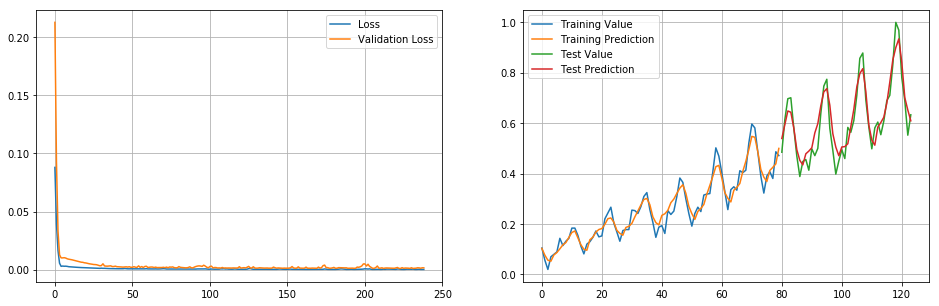

In [27]:
plot_model_results(model)

## Using Recurrent Neural Network (RNN)

Recurrent neural networks can be used to account for the sequential/temporal dependencies between for the input data set.

In [30]:
config = Config(batch_size=50, look_back=15, n_epochs=2000, train_portion=0.7, min_delta = 0.00001, rnn_nodes=15, stop_patience=200, lr_patience=100)

In [31]:
# Creating sequential data set
trainX, trainY, testX, testY = time_data.create_sequential_data(look_back=config.look_back, train_portion=config.train_portion)

# Add channel dimension
trainX = trainX[:, :, np.newaxis]
testX = testX[:, :, np.newaxis]

### Simple RNN

Simple recurrent neural network

In [32]:
# create and fit the RNN
model = Sequential(name='RnnSequential')

model.add(SimpleRNN(config.rnn_nodes, input_shape=(config.look_back, 1),name='SimpleRNN')) # the size of the output layer is always rrn_nodes no matter using LSTM or RNN or GRU

model.add(Dense(1, activation="linear", name='Output'))

model.compile(loss='mse', optimizer=Nadam(learning_rate=0.001))

model.summary()

Model: "RnnSequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
SimpleRNN (SimpleRNN)        (None, 15)                255       
_________________________________________________________________
Output (Dense)               (None, 1)                 16        
Total params: 271
Trainable params: 271
Non-trainable params: 0
_________________________________________________________________


In [33]:
history = model.fit(trainX, trainY, epochs=config.n_epochs, 
                    batch_size=config.batch_size, validation_data=(testX, testY), callbacks=[config.early_stop_clbk, config.lr_plan])

Train on 85 samples, validate on 44 samples
Epoch 1/2000
85/85 [==============================] - 1s 13ms/sample - loss: 0.2354 - val_loss: 0.8194
Epoch 2/2000
85/85 [==============================] - 0s 294us/sample - loss: 0.1862 - val_loss: 0.7276
Epoch 3/2000
85/85 [==============================] - 0s 271us/sample - loss: 0.1513 - val_loss: 0.6394
Epoch 4/2000
85/85 [==============================] - 0s 306us/sample - loss: 0.1214 - val_loss: 0.5581
Epoch 5/2000
85/85 [==============================] - 0s 247us/sample - loss: 0.0946 - val_loss: 0.4799
Epoch 6/2000
85/85 [==============================] - 0s 294us/sample - loss: 0.0715 - val_loss: 0.4075
Epoch 7/2000
85/85 [==============================] - 0s 259us/sample - loss: 0.0532 - val_loss: 0.3446
Epoch 8/2000
85/85 [==============================] - 0s 212us/sample - loss: 0.0388 - val_loss: 0.2901
Epoch 9/2000
85/85 [==============================] - 0s 247us/sample - loss: 0.0275 - val_loss: 0.2430
Epoch 10/2000
85/85 [

85/85 [==============================] - 0s 212us/sample - loss: 0.0021 - val_loss: 0.0372
Epoch 79/2000
85/85 [==============================] - 0s 235us/sample - loss: 0.0021 - val_loss: 0.0371
Epoch 80/2000
85/85 [==============================] - 0s 224us/sample - loss: 0.0020 - val_loss: 0.0370
Epoch 81/2000
85/85 [==============================] - 0s 235us/sample - loss: 0.0020 - val_loss: 0.0374
Epoch 82/2000
85/85 [==============================] - 0s 212us/sample - loss: 0.0020 - val_loss: 0.0366
Epoch 83/2000
85/85 [==============================] - 0s 235us/sample - loss: 0.0020 - val_loss: 0.0361
Epoch 84/2000
85/85 [==============================] - 0s 212us/sample - loss: 0.0020 - val_loss: 0.0363
Epoch 85/2000
85/85 [==============================] - 0s 235us/sample - loss: 0.0020 - val_loss: 0.0355
Epoch 86/2000
85/85 [==============================] - 0s 224us/sample - loss: 0.0019 - val_loss: 0.0354
Epoch 87/2000
85/85 [==============================] - 0s 247us/sampl

85/85 [==============================] - 0s 235us/sample - loss: 0.0012 - val_loss: 0.0214
Epoch 156/2000
85/85 [==============================] - 0s 223us/sample - loss: 0.0012 - val_loss: 0.0215
Epoch 157/2000
85/85 [==============================] - 0s 212us/sample - loss: 0.0012 - val_loss: 0.0212
Epoch 158/2000
85/85 [==============================] - 0s 211us/sample - loss: 0.0012 - val_loss: 0.0218
Epoch 159/2000
85/85 [==============================] - 0s 235us/sample - loss: 0.0012 - val_loss: 0.0213
Epoch 160/2000
85/85 [==============================] - 0s 212us/sample - loss: 0.0012 - val_loss: 0.0209
Epoch 161/2000
85/85 [==============================] - 0s 212us/sample - loss: 0.0012 - val_loss: 0.0204
Epoch 162/2000
85/85 [==============================] - 0s 212us/sample - loss: 0.0012 - val_loss: 0.0210
Epoch 163/2000
85/85 [==============================] - 0s 212us/sample - loss: 0.0012 - val_loss: 0.0206
Epoch 164/2000
85/85 [==============================] - 0s 21

Epoch 231/2000
85/85 [==============================] - 0s 212us/sample - loss: 8.2627e-04 - val_loss: 0.0138
Epoch 232/2000
85/85 [==============================] - 0s 212us/sample - loss: 8.2848e-04 - val_loss: 0.0136
Epoch 233/2000
85/85 [==============================] - 0s 212us/sample - loss: 8.4429e-04 - val_loss: 0.0144
Epoch 234/2000
85/85 [==============================] - 0s 212us/sample - loss: 8.9120e-04 - val_loss: 0.0145
Epoch 235/2000
85/85 [==============================] - 0s 212us/sample - loss: 8.3242e-04 - val_loss: 0.0136
Epoch 236/2000
85/85 [==============================] - 0s 223us/sample - loss: 8.1741e-04 - val_loss: 0.0135
Epoch 237/2000
85/85 [==============================] - 0s 212us/sample - loss: 8.1281e-04 - val_loss: 0.0138
Epoch 238/2000
85/85 [==============================] - 0s 212us/sample - loss: 8.1723e-04 - val_loss: 0.0137
Epoch 239/2000
85/85 [==============================] - 0s 212us/sample - loss: 8.2239e-04 - val_loss: 0.0127
Epoch 240/

85/85 [==============================] - 0s 212us/sample - loss: 6.6452e-04 - val_loss: 0.0095
Epoch 306/2000
85/85 [==============================] - 0s 212us/sample - loss: 6.6149e-04 - val_loss: 0.0095
Epoch 307/2000
85/85 [==============================] - 0s 212us/sample - loss: 6.5971e-04 - val_loss: 0.0095
Epoch 308/2000
85/85 [==============================] - 0s 212us/sample - loss: 6.6261e-04 - val_loss: 0.0096
Epoch 309/2000
85/85 [==============================] - 0s 224us/sample - loss: 6.5782e-04 - val_loss: 0.0095
Epoch 310/2000
85/85 [==============================] - 0s 212us/sample - loss: 6.4770e-04 - val_loss: 0.0093
Epoch 311/2000
85/85 [==============================] - 0s 188us/sample - loss: 6.5429e-04 - val_loss: 0.0098
Epoch 312/2000
85/85 [==============================] - 0s 188us/sample - loss: 6.6759e-04 - val_loss: 0.0088
Epoch 313/2000
85/85 [==============================] - 0s 200us/sample - loss: 7.0403e-04 - val_loss: 0.0091
Epoch 314/2000
85/85 [===

85/85 [==============================] - 0s 212us/sample - loss: 5.7134e-04 - val_loss: 0.0070
Epoch 380/2000
85/85 [==============================] - 0s 224us/sample - loss: 6.0373e-04 - val_loss: 0.0069
Epoch 381/2000
85/85 [==============================] - 0s 223us/sample - loss: 5.9177e-04 - val_loss: 0.0069
Epoch 382/2000
85/85 [==============================] - 0s 212us/sample - loss: 5.7098e-04 - val_loss: 0.0074
Epoch 383/2000
85/85 [==============================] - 0s 224us/sample - loss: 5.6931e-04 - val_loss: 0.0071
Epoch 384/2000
85/85 [==============================] - 0s 223us/sample - loss: 6.1036e-04 - val_loss: 0.0067
Epoch 385/2000
85/85 [==============================] - 0s 200us/sample - loss: 5.8089e-04 - val_loss: 0.0074
Epoch 386/2000
85/85 [==============================] - 0s 200us/sample - loss: 5.7888e-04 - val_loss: 0.0072
Epoch 387/2000
85/85 [==============================] - 0s 212us/sample - loss: 5.6142e-04 - val_loss: 0.0070
Epoch 388/2000
85/85 [===

85/85 [==============================] - 0s 212us/sample - loss: 5.2934e-04 - val_loss: 0.0058
Epoch 454/2000
85/85 [==============================] - 0s 200us/sample - loss: 5.5927e-04 - val_loss: 0.0062
Epoch 455/2000
85/85 [==============================] - 0s 212us/sample - loss: 5.4493e-04 - val_loss: 0.0055
Epoch 456/2000
85/85 [==============================] - 0s 200us/sample - loss: 5.5271e-04 - val_loss: 0.0060
Epoch 457/2000
85/85 [==============================] - 0s 224us/sample - loss: 5.2877e-04 - val_loss: 0.0059
Epoch 458/2000
85/85 [==============================] - 0s 212us/sample - loss: 6.3259e-04 - val_loss: 0.0066
Epoch 459/2000
85/85 [==============================] - 0s 212us/sample - loss: 5.9684e-04 - val_loss: 0.0057
Epoch 460/2000
85/85 [==============================] - 0s 224us/sample - loss: 5.3265e-04 - val_loss: 0.0062
Epoch 461/2000
85/85 [==============================] - 0s 212us/sample - loss: 5.2977e-04 - val_loss: 0.0057
Epoch 462/2000
85/85 [===

85/85 [==============================] - 0s 247us/sample - loss: 6.0357e-04 - val_loss: 0.0048
Epoch 528/2000
85/85 [==============================] - 0s 294us/sample - loss: 5.2632e-04 - val_loss: 0.0048
Epoch 529/2000
85/85 [==============================] - 0s 306us/sample - loss: 5.0062e-04 - val_loss: 0.0050
Epoch 530/2000
85/85 [==============================] - 0s 247us/sample - loss: 4.9218e-04 - val_loss: 0.0049
Epoch 531/2000
85/85 [==============================] - 0s 224us/sample - loss: 4.9640e-04 - val_loss: 0.0050
Epoch 532/2000
85/85 [==============================] - 0s 211us/sample - loss: 4.9336e-04 - val_loss: 0.0050
Epoch 533/2000
85/85 [==============================] - 0s 223us/sample - loss: 4.8891e-04 - val_loss: 0.0049
Epoch 534/2000
85/85 [==============================] - 0s 247us/sample - loss: 4.8959e-04 - val_loss: 0.0050
Epoch 535/2000
85/85 [==============================] - 0s 235us/sample - loss: 4.9458e-04 - val_loss: 0.0050
Epoch 536/2000
85/85 [===

85/85 [==============================] - 0s 247us/sample - loss: 4.7505e-04 - val_loss: 0.0042
Epoch 602/2000
85/85 [==============================] - 0s 212us/sample - loss: 4.7801e-04 - val_loss: 0.0045
Epoch 603/2000
85/85 [==============================] - 0s 235us/sample - loss: 4.7047e-04 - val_loss: 0.0042
Epoch 604/2000
85/85 [==============================] - 0s 247us/sample - loss: 5.0620e-04 - val_loss: 0.0048
Epoch 605/2000
85/85 [==============================] - 0s 247us/sample - loss: 5.6738e-04 - val_loss: 0.0044
Epoch 606/2000
85/85 [==============================] - 0s 247us/sample - loss: 5.0071e-04 - val_loss: 0.0047
Epoch 607/2000
85/85 [==============================] - 0s 247us/sample - loss: 5.0114e-04 - val_loss: 0.0042
Epoch 608/2000
85/85 [==============================] - 0s 259us/sample - loss: 4.7956e-04 - val_loss: 0.0043
Epoch 609/2000
85/85 [==============================] - 0s 223us/sample - loss: 4.8152e-04 - val_loss: 0.0042
Epoch 610/2000
85/85 [===

85/85 [==============================] - 0s 235us/sample - loss: 4.5364e-04 - val_loss: 0.0038
Epoch 676/2000
85/85 [==============================] - 0s 224us/sample - loss: 4.9370e-04 - val_loss: 0.0037
Epoch 677/2000
85/85 [==============================] - 0s 224us/sample - loss: 4.6768e-04 - val_loss: 0.0040
Epoch 678/2000
85/85 [==============================] - 0s 212us/sample - loss: 4.5845e-04 - val_loss: 0.0037
Epoch 679/2000
85/85 [==============================] - 0s 212us/sample - loss: 4.9141e-04 - val_loss: 0.0038
Epoch 680/2000
85/85 [==============================] - 0s 200us/sample - loss: 5.0918e-04 - val_loss: 0.0037
Epoch 681/2000
85/85 [==============================] - 0s 200us/sample - loss: 5.0366e-04 - val_loss: 0.0038
Epoch 682/2000
85/85 [==============================] - 0s 200us/sample - loss: 4.5550e-04 - val_loss: 0.0039
Epoch 683/2000
85/85 [==============================] - 0s 200us/sample - loss: 5.4716e-04 - val_loss: 0.0042
Epoch 684/2000
85/85 [===

85/85 [==============================] - 0s 212us/sample - loss: 4.7151e-04 - val_loss: 0.0035
Epoch 750/2000
85/85 [==============================] - 0s 212us/sample - loss: 4.4020e-04 - val_loss: 0.0035
Epoch 751/2000
85/85 [==============================] - 0s 200us/sample - loss: 4.8668e-04 - val_loss: 0.0034
Epoch 752/2000
85/85 [==============================] - 0s 212us/sample - loss: 4.9489e-04 - val_loss: 0.0035
Epoch 753/2000
85/85 [==============================] - 0s 212us/sample - loss: 4.3807e-04 - val_loss: 0.0035
Epoch 754/2000
85/85 [==============================] - 0s 200us/sample - loss: 4.3685e-04 - val_loss: 0.0035
Epoch 755/2000
85/85 [==============================] - 0s 200us/sample - loss: 4.3739e-04 - val_loss: 0.0035
Epoch 756/2000
85/85 [==============================] - 0s 200us/sample - loss: 4.6506e-04 - val_loss: 0.0036
Epoch 757/2000
85/85 [==============================] - 0s 188us/sample - loss: 4.4512e-04 - val_loss: 0.0035
Epoch 758/2000
85/85 [===

85/85 [==============================] - 0s 212us/sample - loss: 4.4878e-04 - val_loss: 0.0032
Epoch 824/2000
85/85 [==============================] - 0s 224us/sample - loss: 4.4653e-04 - val_loss: 0.0032
Epoch 825/2000
85/85 [==============================] - 0s 212us/sample - loss: 4.5522e-04 - val_loss: 0.0031
Epoch 826/2000
85/85 [==============================] - 0s 200us/sample - loss: 6.0482e-04 - val_loss: 0.0032
Epoch 827/2000
85/85 [==============================] - 0s 212us/sample - loss: 5.0095e-04 - val_loss: 0.0034
Epoch 828/2000
85/85 [==============================] - 0s 224us/sample - loss: 4.2735e-04 - val_loss: 0.0032
Epoch 829/2000
85/85 [==============================] - 0s 224us/sample - loss: 4.2821e-04 - val_loss: 0.0033
Epoch 830/2000
85/85 [==============================] - 0s 212us/sample - loss: 4.3052e-04 - val_loss: 0.0032
Epoch 831/2000
85/85 [==============================] - 0s 200us/sample - loss: 4.6590e-04 - val_loss: 0.0032
Epoch 832/2000
85/85 [===

85/85 [==============================] - 0s 224us/sample - loss: 4.2777e-04 - val_loss: 0.0030
Epoch 898/2000
85/85 [==============================] - 0s 212us/sample - loss: 4.1738e-04 - val_loss: 0.0029
Epoch 899/2000
85/85 [==============================] - 0s 211us/sample - loss: 4.6125e-04 - val_loss: 0.0030
Epoch 900/2000
85/85 [==============================] - 0s 212us/sample - loss: 4.9815e-04 - val_loss: 0.0030
Epoch 901/2000
85/85 [==============================] - 0s 212us/sample - loss: 4.3053e-04 - val_loss: 0.0031
Epoch 902/2000
85/85 [==============================] - 0s 200us/sample - loss: 5.0224e-04 - val_loss: 0.0030
Epoch 903/2000
85/85 [==============================] - 0s 224us/sample - loss: 4.3085e-04 - val_loss: 0.0030
Epoch 904/2000
85/85 [==============================] - 0s 224us/sample - loss: 4.4758e-04 - val_loss: 0.0031
Epoch 905/2000
85/85 [==============================] - 0s 200us/sample - loss: 4.5704e-04 - val_loss: 0.0030
Epoch 906/2000
85/85 [===

85/85 [==============================] - 0s 200us/sample - loss: 4.5298e-04 - val_loss: 0.0029
Epoch 972/2000
85/85 [==============================] - 0s 200us/sample - loss: 4.1467e-04 - val_loss: 0.0028
Epoch 973/2000
85/85 [==============================] - 0s 212us/sample - loss: 4.0524e-04 - val_loss: 0.0029
Epoch 974/2000
85/85 [==============================] - 0s 212us/sample - loss: 4.0691e-04 - val_loss: 0.0028
Epoch 975/2000
85/85 [==============================] - 0s 200us/sample - loss: 4.1487e-04 - val_loss: 0.0029
Epoch 976/2000
85/85 [==============================] - 0s 200us/sample - loss: 4.0623e-04 - val_loss: 0.0028
Epoch 977/2000
85/85 [==============================] - 0s 200us/sample - loss: 4.5346e-04 - val_loss: 0.0027
Epoch 978/2000
85/85 [==============================] - 0s 200us/sample - loss: 4.6608e-04 - val_loss: 0.0028
Epoch 979/2000
85/85 [==============================] - 0s 200us/sample - loss: 4.1927e-04 - val_loss: 0.0027
Epoch 980/2000
85/85 [===

Epoch 1045/2000
85/85 [==============================] - 0s 224us/sample - loss: 3.9959e-04 - val_loss: 0.0027
Epoch 1046/2000
85/85 [==============================] - 0s 224us/sample - loss: 4.0216e-04 - val_loss: 0.0027
Epoch 1047/2000
85/85 [==============================] - 0s 200us/sample - loss: 4.1792e-04 - val_loss: 0.0026
Epoch 1048/2000
85/85 [==============================] - 0s 200us/sample - loss: 3.9555e-04 - val_loss: 0.0026
Epoch 1049/2000
85/85 [==============================] - 0s 200us/sample - loss: 3.9452e-04 - val_loss: 0.0026
Epoch 1050/2000
85/85 [==============================] - 0s 200us/sample - loss: 4.0451e-04 - val_loss: 0.0026
Epoch 1051/2000
85/85 [==============================] - 0s 212us/sample - loss: 4.0180e-04 - val_loss: 0.0026
Epoch 1052/2000
85/85 [==============================] - 0s 212us/sample - loss: 3.9410e-04 - val_loss: 0.0026
Epoch 1053/2000
85/85 [==============================] - 0s 212us/sample - loss: 4.0068e-04 - val_loss: 0.0026
E

85/85 [==============================] - 0s 212us/sample - loss: 3.9336e-04 - val_loss: 0.0026
Epoch 1119/2000
85/85 [==============================] - 0s 224us/sample - loss: 3.9567e-04 - val_loss: 0.0025
Epoch 1120/2000
85/85 [==============================] - 0s 212us/sample - loss: 4.2601e-04 - val_loss: 0.0025
Epoch 1121/2000
85/85 [==============================] - 0s 223us/sample - loss: 4.7973e-04 - val_loss: 0.0025
Epoch 1122/2000
85/85 [==============================] - 0s 188us/sample - loss: 4.5858e-04 - val_loss: 0.0025
Epoch 1123/2000
85/85 [==============================] - 0s 200us/sample - loss: 4.2290e-04 - val_loss: 0.0025
Epoch 1124/2000
85/85 [==============================] - 0s 200us/sample - loss: 4.0937e-04 - val_loss: 0.0025
Epoch 1125/2000
85/85 [==============================] - 0s 212us/sample - loss: 3.9552e-04 - val_loss: 0.0025
Epoch 1126/2000
85/85 [==============================] - 0s 212us/sample - loss: 3.9884e-04 - val_loss: 0.0025
Epoch 1127/2000
8

Epoch 1192/2000
85/85 [==============================] - 0s 306us/sample - loss: 3.9586e-04 - val_loss: 0.0024
Epoch 1193/2000
85/85 [==============================] - 0s 306us/sample - loss: 4.5563e-04 - val_loss: 0.0023
Epoch 1194/2000
85/85 [==============================] - 0s 329us/sample - loss: 4.0184e-04 - val_loss: 0.0023
Epoch 1195/2000
85/85 [==============================] - 0s 341us/sample - loss: 3.9636e-04 - val_loss: 0.0023
Epoch 1196/2000
85/85 [==============================] - 0s 282us/sample - loss: 3.9984e-04 - val_loss: 0.0023
Epoch 1197/2000
85/85 [==============================] - 0s 271us/sample - loss: 3.8438e-04 - val_loss: 0.0023
Epoch 1198/2000
85/85 [==============================] - 0s 223us/sample - loss: 3.8028e-04 - val_loss: 0.0023
Epoch 1199/2000
85/85 [==============================] - 0s 212us/sample - loss: 3.9284e-04 - val_loss: 0.0023
Epoch 1200/2000
85/85 [==============================] - 0s 259us/sample - loss: 3.7932e-04 - val_loss: 0.0023
E

Epoch 1266/2000
85/85 [==============================] - 0s 235us/sample - loss: 3.7155e-04 - val_loss: 0.0022
Epoch 1267/2000
85/85 [==============================] - 0s 212us/sample - loss: 3.7926e-04 - val_loss: 0.0022
Epoch 1268/2000
85/85 [==============================] - 0s 212us/sample - loss: 3.7531e-04 - val_loss: 0.0022
Epoch 1269/2000
85/85 [==============================] - 0s 212us/sample - loss: 3.7567e-04 - val_loss: 0.0022
Epoch 1270/2000
85/85 [==============================] - 0s 200us/sample - loss: 3.8213e-04 - val_loss: 0.0022
Epoch 1271/2000
85/85 [==============================] - 0s 200us/sample - loss: 3.7397e-04 - val_loss: 0.0022
Epoch 1272/2000
85/85 [==============================] - 0s 224us/sample - loss: 3.7171e-04 - val_loss: 0.0022
Epoch 1273/2000
85/85 [==============================] - 0s 212us/sample - loss: 3.8061e-04 - val_loss: 0.0022
Epoch 1274/2000
85/85 [==============================] - 0s 212us/sample - loss: 3.7377e-04 - val_loss: 0.0022
E

Epoch 1340/2000
85/85 [==============================] - 0s 212us/sample - loss: 3.7457e-04 - val_loss: 0.0021
Epoch 1341/2000
85/85 [==============================] - 0s 212us/sample - loss: 4.2793e-04 - val_loss: 0.0021
Epoch 1342/2000
85/85 [==============================] - 0s 235us/sample - loss: 3.7160e-04 - val_loss: 0.0021
Epoch 1343/2000
85/85 [==============================] - 0s 235us/sample - loss: 3.9103e-04 - val_loss: 0.0021
Epoch 1344/2000
85/85 [==============================] - 0s 247us/sample - loss: 3.8163e-04 - val_loss: 0.0021
Epoch 1345/2000
85/85 [==============================] - 0s 247us/sample - loss: 3.6697e-04 - val_loss: 0.0021
Epoch 1346/2000
85/85 [==============================] - 0s 247us/sample - loss: 3.7752e-04 - val_loss: 0.0021
Epoch 1347/2000
85/85 [==============================] - 0s 259us/sample - loss: 3.8019e-04 - val_loss: 0.0021
Epoch 1348/2000
85/85 [==============================] - 0s 306us/sample - loss: 4.1154e-04 - val_loss: 0.0021
E

85/85 [==============================] - 0s 247us/sample - loss: 3.6843e-04 - val_loss: 0.0021
Epoch 1414/2000
85/85 [==============================] - 0s 271us/sample - loss: 3.8578e-04 - val_loss: 0.0020
Epoch 1415/2000
85/85 [==============================] - 0s 306us/sample - loss: 3.6443e-04 - val_loss: 0.0020
Epoch 1416/2000
85/85 [==============================] - 0s 235us/sample - loss: 3.5780e-04 - val_loss: 0.0020
Epoch 1417/2000
85/85 [==============================] - 0s 271us/sample - loss: 3.6345e-04 - val_loss: 0.0021
Epoch 1418/2000
85/85 [==============================] - 0s 259us/sample - loss: 4.7274e-04 - val_loss: 0.0022
Epoch 1419/2000
85/85 [==============================] - 0s 235us/sample - loss: 4.3463e-04 - val_loss: 0.0020
Epoch 1420/2000
85/85 [==============================] - 0s 235us/sample - loss: 3.6025e-04 - val_loss: 0.0020
Epoch 1421/2000
85/85 [==============================] - 0s 294us/sample - loss: 3.6857e-04 - val_loss: 0.0021
Epoch 1422/2000
8

Epoch 1487/2000
85/85 [==============================] - 0s 200us/sample - loss: 3.6823e-04 - val_loss: 0.0019
Epoch 1488/2000
85/85 [==============================] - 0s 200us/sample - loss: 3.6691e-04 - val_loss: 0.0020
Epoch 1489/2000
85/85 [==============================] - 0s 224us/sample - loss: 5.0269e-04 - val_loss: 0.0020
Epoch 1490/2000
85/85 [==============================] - 0s 200us/sample - loss: 4.3184e-04 - val_loss: 0.0020
Epoch 1491/2000
85/85 [==============================] - 0s 212us/sample - loss: 3.5854e-04 - val_loss: 0.0019
Epoch 1492/2000
85/85 [==============================] - 0s 200us/sample - loss: 3.5504e-04 - val_loss: 0.0020
Epoch 1493/2000
85/85 [==============================] - 0s 247us/sample - loss: 3.5936e-04 - val_loss: 0.0019
Epoch 1494/2000
85/85 [==============================] - 0s 200us/sample - loss: 3.6042e-04 - val_loss: 0.0019
Epoch 1495/2000
85/85 [==============================] - 0s 212us/sample - loss: 3.6717e-04 - val_loss: 0.0019
E

Epoch 1561/2000
85/85 [==============================] - 0s 224us/sample - loss: 3.5093e-04 - val_loss: 0.0019
Epoch 1562/2000
85/85 [==============================] - 0s 224us/sample - loss: 3.9230e-04 - val_loss: 0.0020
Epoch 1563/2000
85/85 [==============================] - 0s 212us/sample - loss: 3.8183e-04 - val_loss: 0.0020
Epoch 1564/2000
85/85 [==============================] - 0s 212us/sample - loss: 4.3868e-04 - val_loss: 0.0020
Epoch 1565/2000
85/85 [==============================] - 0s 223us/sample - loss: 4.1149e-04 - val_loss: 0.0019
Epoch 1566/2000
85/85 [==============================] - 0s 282us/sample - loss: 3.7262e-04 - val_loss: 0.0020
Epoch 1567/2000
85/85 [==============================] - 0s 271us/sample - loss: 3.5301e-04 - val_loss: 0.0019
Epoch 1568/2000
85/85 [==============================] - 0s 282us/sample - loss: 3.6709e-04 - val_loss: 0.0019
Epoch 1569/2000
85/85 [==============================] - 0s 259us/sample - loss: 3.5988e-04 - val_loss: 0.0019
E

Epoch 1635/2000
85/85 [==============================] - 0s 212us/sample - loss: 3.6104e-04 - val_loss: 0.0019
Epoch 1636/2000
85/85 [==============================] - 0s 212us/sample - loss: 3.5471e-04 - val_loss: 0.0019
Epoch 1637/2000
85/85 [==============================] - 0s 200us/sample - loss: 3.9141e-04 - val_loss: 0.0019
Epoch 1638/2000
85/85 [==============================] - 0s 212us/sample - loss: 3.8079e-04 - val_loss: 0.0018
Epoch 1639/2000
85/85 [==============================] - 0s 223us/sample - loss: 3.4081e-04 - val_loss: 0.0018
Epoch 1640/2000
85/85 [==============================] - 0s 223us/sample - loss: 3.4231e-04 - val_loss: 0.0018
Epoch 1641/2000
85/85 [==============================] - 0s 212us/sample - loss: 3.4215e-04 - val_loss: 0.0018
Epoch 1642/2000
85/85 [==============================] - 0s 212us/sample - loss: 3.4686e-04 - val_loss: 0.0018
Epoch 1643/2000
85/85 [==============================] - 0s 212us/sample - loss: 3.4208e-04 - val_loss: 0.0018
E

Epoch 1709/2000
85/85 [==============================] - 0s 247us/sample - loss: 3.3973e-04 - val_loss: 0.0017
Epoch 1710/2000
85/85 [==============================] - 0s 235us/sample - loss: 3.6172e-04 - val_loss: 0.0018
Epoch 1711/2000
85/85 [==============================] - 0s 200us/sample - loss: 3.8600e-04 - val_loss: 0.0017
Epoch 1712/2000
85/85 [==============================] - 0s 212us/sample - loss: 3.8704e-04 - val_loss: 0.0019
Epoch 1713/2000
85/85 [==============================] - 0s 200us/sample - loss: 4.4450e-04 - val_loss: 0.0018
Epoch 1714/2000
85/85 [==============================] - 0s 223us/sample - loss: 3.3503e-04 - val_loss: 0.0018
Epoch 1715/2000
85/85 [==============================] - 0s 200us/sample - loss: 3.3830e-04 - val_loss: 0.0018
Epoch 1716/2000
85/85 [==============================] - 0s 200us/sample - loss: 3.4967e-04 - val_loss: 0.0018
Epoch 1717/2000
85/85 [==============================] - 0s 212us/sample - loss: 3.5185e-04 - val_loss: 0.0018
E

85/85 [==============================] - 0s 200us/sample - loss: 3.3701e-04 - val_loss: 0.0017
Epoch 1783/2000
85/85 [==============================] - 0s 224us/sample - loss: 3.5019e-04 - val_loss: 0.0017
Epoch 1784/2000
85/85 [==============================] - 0s 212us/sample - loss: 3.3776e-04 - val_loss: 0.0017
Epoch 1785/2000
85/85 [==============================] - 0s 200us/sample - loss: 3.3415e-04 - val_loss: 0.0017
Epoch 1786/2000
85/85 [==============================] - 0s 212us/sample - loss: 3.4507e-04 - val_loss: 0.0017
Epoch 1787/2000
85/85 [==============================] - 0s 212us/sample - loss: 3.3198e-04 - val_loss: 0.0017
Epoch 1788/2000
85/85 [==============================] - 0s 200us/sample - loss: 3.3664e-04 - val_loss: 0.0017
Epoch 1789/2000
85/85 [==============================] - 0s 200us/sample - loss: 3.4031e-04 - val_loss: 0.0017
Epoch 1790/2000
85/85 [==============================] - 0s 223us/sample - loss: 3.7583e-04 - val_loss: 0.0017
Epoch 1791/2000
8

Epoch 1856/2000
85/85 [==============================] - 0s 212us/sample - loss: 3.8280e-04 - val_loss: 0.0017
Epoch 1857/2000
85/85 [==============================] - 0s 212us/sample - loss: 3.3449e-04 - val_loss: 0.0017
Epoch 1858/2000
85/85 [==============================] - 0s 212us/sample - loss: 3.5639e-04 - val_loss: 0.0017
Epoch 1859/2000
85/85 [==============================] - 0s 200us/sample - loss: 3.2956e-04 - val_loss: 0.0017
Epoch 1860/2000
85/85 [==============================] - 0s 212us/sample - loss: 3.2849e-04 - val_loss: 0.0017
Epoch 1861/2000
85/85 [==============================] - 0s 212us/sample - loss: 3.3067e-04 - val_loss: 0.0017
Epoch 1862/2000
85/85 [==============================] - 0s 200us/sample - loss: 3.3440e-04 - val_loss: 0.0017
Epoch 1863/2000
85/85 [==============================] - 0s 200us/sample - loss: 3.5288e-04 - val_loss: 0.0018
Epoch 1864/2000
85/85 [==============================] - 0s 212us/sample - loss: 4.4186e-04 - val_loss: 0.0017
E

85/85 [==============================] - 0s 200us/sample - loss: 3.3012e-04 - val_loss: 0.0016
Epoch 1930/2000
85/85 [==============================] - 0s 224us/sample - loss: 3.2130e-04 - val_loss: 0.0016
Epoch 1931/2000
85/85 [==============================] - 0s 212us/sample - loss: 3.3746e-04 - val_loss: 0.0016
Epoch 1932/2000
85/85 [==============================] - 0s 212us/sample - loss: 3.3959e-04 - val_loss: 0.0016
Epoch 1933/2000
85/85 [==============================] - 0s 212us/sample - loss: 3.3454e-04 - val_loss: 0.0016
Epoch 1934/2000
85/85 [==============================] - 0s 200us/sample - loss: 3.2028e-04 - val_loss: 0.0016
Epoch 1935/2000
85/85 [==============================] - 0s 200us/sample - loss: 3.2353e-04 - val_loss: 0.0016
Epoch 1936/2000
85/85 [==============================] - 0s 212us/sample - loss: 3.5322e-04 - val_loss: 0.0016
Epoch 1937/2000
85/85 [==============================] - 0s 212us/sample - loss: 3.6935e-04 - val_loss: 0.0016
Epoch 1938/2000
8

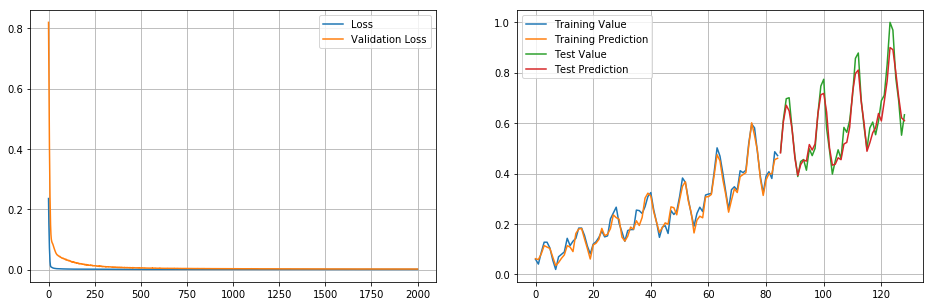

In [34]:
plot_model_results(model)

### LSTM

Using Long Short Term Memory recurrent neural networks

In [35]:
config.look_back = 5
# Creating sequential data set
trainX, trainY, testX, testY = time_data.create_sequential_data(look_back=config.look_back, train_portion=config.train_portion)

# Add channel dimension
trainX = trainX[:, :, np.newaxis]
testX = testX[:, :, np.newaxis]

In [36]:
# create and fit the RNN
model = Sequential(name='RnnSequential')

model.add(LSTM(config.rnn_nodes, input_shape=(config.look_back, 1),name='LSTM')) # the size of the output layer is always rrn_nodes no matter using LSTM or RNN or GRU

model.add(Dense(1, activation="linear", name='Output'))

model.compile(loss='mse', optimizer=Nadam(learning_rate=0.001))

model.summary()

Model: "RnnSequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM (LSTM)                  (None, 15)                1020      
_________________________________________________________________
Output (Dense)               (None, 1)                 16        
Total params: 1,036
Trainable params: 1,036
Non-trainable params: 0
_________________________________________________________________


In [37]:
history = model.fit(trainX, trainY, epochs=config.n_epochs, 
                    batch_size=config.batch_size, validation_data=(testX, testY), callbacks=[config.early_stop_clbk, config.lr_plan])

Train on 95 samples, validate on 44 samples
Epoch 1/2000
95/95 [==============================] - 2s 21ms/sample - loss: 0.0562 - val_loss: 0.2874
Epoch 2/2000
95/95 [==============================] - 0s 242us/sample - loss: 0.0517 - val_loss: 0.2728
Epoch 3/2000
95/95 [==============================] - 0s 263us/sample - loss: 0.0480 - val_loss: 0.2579
Epoch 4/2000
95/95 [==============================] - 0s 263us/sample - loss: 0.0443 - val_loss: 0.2429
Epoch 5/2000
95/95 [==============================] - 0s 274us/sample - loss: 0.0406 - val_loss: 0.2274
Epoch 6/2000
95/95 [==============================] - 0s 253us/sample - loss: 0.0370 - val_loss: 0.2120
Epoch 7/2000
95/95 [==============================] - 0s 252us/sample - loss: 0.0335 - val_loss: 0.1968
Epoch 8/2000
95/95 [==============================] - 0s 221us/sample - loss: 0.0301 - val_loss: 0.1819
Epoch 9/2000
95/95 [==============================] - 0s 200us/sample - loss: 0.0270 - val_loss: 0.1675
Epoch 10/2000
95/95 [

95/95 [==============================] - 0s 189us/sample - loss: 0.0050 - val_loss: 0.0250
Epoch 79/2000
95/95 [==============================] - 0s 179us/sample - loss: 0.0050 - val_loss: 0.0250
Epoch 80/2000
95/95 [==============================] - 0s 179us/sample - loss: 0.0050 - val_loss: 0.0249
Epoch 81/2000
95/95 [==============================] - 0s 158us/sample - loss: 0.0050 - val_loss: 0.0248
Epoch 82/2000
95/95 [==============================] - 0s 168us/sample - loss: 0.0050 - val_loss: 0.0248
Epoch 83/2000
95/95 [==============================] - 0s 168us/sample - loss: 0.0050 - val_loss: 0.0248
Epoch 84/2000
95/95 [==============================] - 0s 179us/sample - loss: 0.0049 - val_loss: 0.0248
Epoch 85/2000
95/95 [==============================] - 0s 168us/sample - loss: 0.0049 - val_loss: 0.0248
Epoch 86/2000
95/95 [==============================] - 0s 179us/sample - loss: 0.0049 - val_loss: 0.0247
Epoch 87/2000
95/95 [==============================] - 0s 158us/sampl

95/95 [==============================] - 0s 179us/sample - loss: 0.0045 - val_loss: 0.0228
Epoch 156/2000
95/95 [==============================] - 0s 189us/sample - loss: 0.0045 - val_loss: 0.0227
Epoch 157/2000
95/95 [==============================] - 0s 168us/sample - loss: 0.0045 - val_loss: 0.0227
Epoch 158/2000
95/95 [==============================] - 0s 179us/sample - loss: 0.0045 - val_loss: 0.0226
Epoch 159/2000
95/95 [==============================] - 0s 179us/sample - loss: 0.0045 - val_loss: 0.0226
Epoch 160/2000
95/95 [==============================] - 0s 168us/sample - loss: 0.0045 - val_loss: 0.0226
Epoch 161/2000
95/95 [==============================] - 0s 168us/sample - loss: 0.0045 - val_loss: 0.0225
Epoch 162/2000
95/95 [==============================] - 0s 168us/sample - loss: 0.0045 - val_loss: 0.0225
Epoch 163/2000
95/95 [==============================] - 0s 168us/sample - loss: 0.0045 - val_loss: 0.0225
Epoch 164/2000
95/95 [==============================] - 0s 16

95/95 [==============================] - 0s 168us/sample - loss: 0.0041 - val_loss: 0.0199
Epoch 233/2000
95/95 [==============================] - 0s 179us/sample - loss: 0.0041 - val_loss: 0.0198
Epoch 234/2000
95/95 [==============================] - 0s 168us/sample - loss: 0.0042 - val_loss: 0.0198
Epoch 235/2000
95/95 [==============================] - 0s 179us/sample - loss: 0.0041 - val_loss: 0.0197
Epoch 236/2000
95/95 [==============================] - 0s 168us/sample - loss: 0.0041 - val_loss: 0.0197
Epoch 237/2000
95/95 [==============================] - 0s 168us/sample - loss: 0.0041 - val_loss: 0.0197
Epoch 238/2000
95/95 [==============================] - 0s 179us/sample - loss: 0.0041 - val_loss: 0.0196
Epoch 239/2000
95/95 [==============================] - 0s 758us/sample - loss: 0.0041 - val_loss: 0.0196
Epoch 240/2000
95/95 [==============================] - 0s 179us/sample - loss: 0.0041 - val_loss: 0.0196
Epoch 241/2000
95/95 [==============================] - 0s 24

95/95 [==============================] - 0s 168us/sample - loss: 0.0038 - val_loss: 0.0172
Epoch 310/2000
95/95 [==============================] - 0s 168us/sample - loss: 0.0037 - val_loss: 0.0171
Epoch 311/2000
95/95 [==============================] - 0s 179us/sample - loss: 0.0037 - val_loss: 0.0171
Epoch 312/2000
95/95 [==============================] - 0s 158us/sample - loss: 0.0038 - val_loss: 0.0170
Epoch 313/2000
95/95 [==============================] - 0s 168us/sample - loss: 0.0037 - val_loss: 0.0169
Epoch 314/2000
95/95 [==============================] - 0s 168us/sample - loss: 0.0037 - val_loss: 0.0169
Epoch 315/2000
95/95 [==============================] - 0s 179us/sample - loss: 0.0037 - val_loss: 0.0169
Epoch 316/2000
95/95 [==============================] - 0s 168us/sample - loss: 0.0037 - val_loss: 0.0168
Epoch 317/2000
95/95 [==============================] - 0s 168us/sample - loss: 0.0038 - val_loss: 0.0167
Epoch 318/2000
95/95 [==============================] - 0s 18

95/95 [==============================] - 0s 179us/sample - loss: 0.0033 - val_loss: 0.0145
Epoch 387/2000
95/95 [==============================] - 0s 179us/sample - loss: 0.0033 - val_loss: 0.0144
Epoch 388/2000
95/95 [==============================] - 0s 168us/sample - loss: 0.0033 - val_loss: 0.0144
Epoch 389/2000
95/95 [==============================] - 0s 168us/sample - loss: 0.0033 - val_loss: 0.0143
Epoch 390/2000
95/95 [==============================] - 0s 179us/sample - loss: 0.0033 - val_loss: 0.0143
Epoch 391/2000
95/95 [==============================] - 0s 168us/sample - loss: 0.0033 - val_loss: 0.0144
Epoch 392/2000
95/95 [==============================] - 0s 147us/sample - loss: 0.0033 - val_loss: 0.0145
Epoch 393/2000
95/95 [==============================] - 0s 168us/sample - loss: 0.0033 - val_loss: 0.0143
Epoch 394/2000
95/95 [==============================] - 0s 168us/sample - loss: 0.0033 - val_loss: 0.0144
Epoch 395/2000
95/95 [==============================] - 0s 16

95/95 [==============================] - 0s 189us/sample - loss: 0.0029 - val_loss: 0.0134
Epoch 464/2000
95/95 [==============================] - 0s 168us/sample - loss: 0.0029 - val_loss: 0.0135
Epoch 465/2000
95/95 [==============================] - 0s 179us/sample - loss: 0.0029 - val_loss: 0.0131
Epoch 466/2000
95/95 [==============================] - 0s 168us/sample - loss: 0.0029 - val_loss: 0.0132
Epoch 467/2000
95/95 [==============================] - 0s 158us/sample - loss: 0.0029 - val_loss: 0.0132
Epoch 468/2000
95/95 [==============================] - 0s 168us/sample - loss: 0.0029 - val_loss: 0.0131
Epoch 469/2000
95/95 [==============================] - 0s 168us/sample - loss: 0.0028 - val_loss: 0.0133
Epoch 470/2000
95/95 [==============================] - 0s 189us/sample - loss: 0.0030 - val_loss: 0.0139
Epoch 471/2000
95/95 [==============================] - 0s 168us/sample - loss: 0.0029 - val_loss: 0.0134
Epoch 472/2000
95/95 [==============================] - 0s 17

95/95 [==============================] - 0s 189us/sample - loss: 0.0026 - val_loss: 0.0148
Epoch 541/2000
95/95 [==============================] - 0s 168us/sample - loss: 0.0026 - val_loss: 0.0139
Epoch 542/2000
95/95 [==============================] - 0s 179us/sample - loss: 0.0026 - val_loss: 0.0145
Epoch 543/2000
95/95 [==============================] - 0s 179us/sample - loss: 0.0027 - val_loss: 0.0154
Epoch 544/2000
95/95 [==============================] - 0s 168us/sample - loss: 0.0026 - val_loss: 0.0145
Epoch 545/2000
95/95 [==============================] - 0s 168us/sample - loss: 0.0026 - val_loss: 0.0150
Epoch 546/2000
95/95 [==============================] - 0s 158us/sample - loss: 0.0026 - val_loss: 0.0146
Epoch 547/2000
95/95 [==============================] - 0s 168us/sample - loss: 0.0026 - val_loss: 0.0141
Epoch 548/2000
95/95 [==============================] - 0s 168us/sample - loss: 0.0026 - val_loss: 0.0143
Epoch 549/2000
95/95 [==============================] - 0s 16

95/95 [==============================] - 0s 179us/sample - loss: 0.0025 - val_loss: 0.0144
Epoch 618/2000
95/95 [==============================] - 0s 168us/sample - loss: 0.0025 - val_loss: 0.0144
Epoch 619/2000
95/95 [==============================] - 0s 168us/sample - loss: 0.0025 - val_loss: 0.0144
Epoch 620/2000
95/95 [==============================] - 0s 179us/sample - loss: 0.0025 - val_loss: 0.0144
Epoch 621/2000
95/95 [==============================] - 0s 179us/sample - loss: 0.0025 - val_loss: 0.0144
Epoch 622/2000
95/95 [==============================] - 0s 158us/sample - loss: 0.0025 - val_loss: 0.0144
Epoch 623/2000
95/95 [==============================] - 0s 168us/sample - loss: 0.0025 - val_loss: 0.0144
Epoch 624/2000
95/95 [==============================] - 0s 158us/sample - loss: 0.0025 - val_loss: 0.0144
Epoch 625/2000
95/95 [==============================] - 0s 168us/sample - loss: 0.0025 - val_loss: 0.0144
Epoch 626/2000
95/95 [==============================] - ETA: 

95/95 [==============================] - 0s 168us/sample - loss: 0.0024 - val_loss: 0.0144
Epoch 695/2000
95/95 [==============================] - 0s 168us/sample - loss: 0.0024 - val_loss: 0.0144
Epoch 696/2000
95/95 [==============================] - 0s 189us/sample - loss: 0.0024 - val_loss: 0.0143
Epoch 697/2000
95/95 [==============================] - 0s 169us/sample - loss: 0.0024 - val_loss: 0.0143
Epoch 698/2000
95/95 [==============================] - 0s 168us/sample - loss: 0.0024 - val_loss: 0.0143
Epoch 699/2000
95/95 [==============================] - 0s 168us/sample - loss: 0.0024 - val_loss: 0.0143
Epoch 700/2000
95/95 [==============================] - 0s 158us/sample - loss: 0.0024 - val_loss: 0.0143
Epoch 701/2000
95/95 [==============================] - 0s 158us/sample - loss: 0.0024 - val_loss: 0.0143
Epoch 702/2000
95/95 [==============================] - 0s 168us/sample - loss: 0.0024 - val_loss: 0.0143
Epoch 703/2000
95/95 [==============================] - 0s 16

95/95 [==============================] - 0s 168us/sample - loss: 0.0024 - val_loss: 0.0143
Epoch 772/2000
95/95 [==============================] - 0s 168us/sample - loss: 0.0024 - val_loss: 0.0143
Epoch 773/2000
95/95 [==============================] - 0s 168us/sample - loss: 0.0024 - val_loss: 0.0143
Epoch 774/2000
95/95 [==============================] - 0s 169us/sample - loss: 0.0024 - val_loss: 0.0143
Epoch 775/2000
95/95 [==============================] - 0s 179us/sample - loss: 0.0024 - val_loss: 0.0143
Epoch 776/2000
95/95 [==============================] - 0s 158us/sample - loss: 0.0024 - val_loss: 0.0143
Epoch 777/2000
95/95 [==============================] - 0s 179us/sample - loss: 0.0024 - val_loss: 0.0143
Epoch 778/2000
95/95 [==============================] - 0s 158us/sample - loss: 0.0024 - val_loss: 0.0143
Epoch 779/2000
95/95 [==============================] - 0s 168us/sample - loss: 0.0024 - val_loss: 0.0143
Epoch 780/2000
95/95 [==============================] - 0s 16

95/95 [==============================] - 0s 168us/sample - loss: 0.0024 - val_loss: 0.0143
Epoch 849/2000
95/95 [==============================] - 0s 168us/sample - loss: 0.0024 - val_loss: 0.0143
Epoch 850/2000
95/95 [==============================] - 0s 168us/sample - loss: 0.0024 - val_loss: 0.0143
Epoch 851/2000
95/95 [==============================] - 0s 179us/sample - loss: 0.0024 - val_loss: 0.0143
Epoch 852/2000
95/95 [==============================] - 0s 168us/sample - loss: 0.0024 - val_loss: 0.0143
Epoch 853/2000
95/95 [==============================] - 0s 179us/sample - loss: 0.0024 - val_loss: 0.0143
Epoch 854/2000
95/95 [==============================] - 0s 158us/sample - loss: 0.0024 - val_loss: 0.0143
Epoch 855/2000
95/95 [==============================] - 0s 168us/sample - loss: 0.0024 - val_loss: 0.0143
Epoch 856/2000
95/95 [==============================] - 0s 168us/sample - loss: 0.0024 - val_loss: 0.0143
Epoch 857/2000
95/95 [==============================] - 0s 16

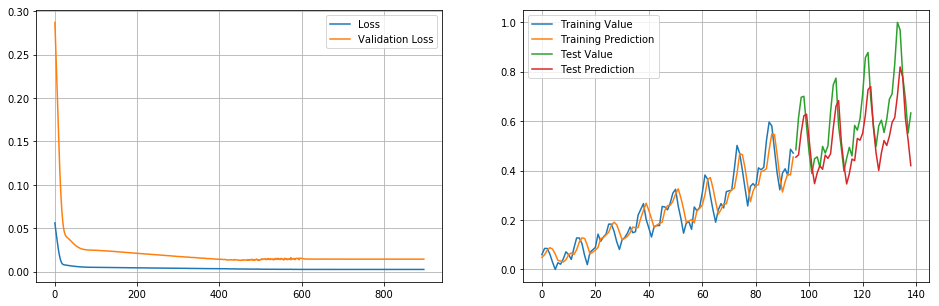

In [38]:
plot_model_results(model)

### GRU

Using gated recurrent neural networks

In [39]:
config.look_back = 5
# Creating sequential data set
trainX, trainY, testX, testY = time_data.create_sequential_data(look_back=config.look_back, train_portion=config.train_portion)

# Add channel dimension
trainX = trainX[:, :, np.newaxis]
testX = testX[:, :, np.newaxis]

In [40]:
# create and fit the RNN
model = Sequential(name='RnnSequential')

model.add(GRU(config.rnn_nodes, input_shape=(config.look_back, 1),name='GRU')) # the size of the output layer is always rrn_nodes no matter using LSTM or RNN or GRU

model.add(Dense(1, activation="linear", name='Output'))

model.compile(loss='mse', optimizer=Nadam(learning_rate=0.001))

model.summary()

Model: "RnnSequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
GRU (GRU)                    (None, 15)                810       
_________________________________________________________________
Output (Dense)               (None, 1)                 16        
Total params: 826
Trainable params: 826
Non-trainable params: 0
_________________________________________________________________


In [41]:
history = model.fit(trainX, trainY, epochs=config.n_epochs, 
                    batch_size=config.batch_size, validation_data=(testX, testY), callbacks=[config.early_stop_clbk, config.lr_plan])

Train on 95 samples, validate on 44 samples
Epoch 1/2000
95/95 [==============================] - 2s 21ms/sample - loss: 0.1410 - val_loss: 0.7510
Epoch 2/2000
95/95 [==============================] - 0s 263us/sample - loss: 0.1310 - val_loss: 0.7202
Epoch 3/2000
95/95 [==============================] - 0s 243us/sample - loss: 0.1227 - val_loss: 0.6892
Epoch 4/2000
95/95 [==============================] - 0s 274us/sample - loss: 0.1145 - val_loss: 0.6572
Epoch 5/2000
95/95 [==============================] - 0s 253us/sample - loss: 0.1062 - val_loss: 0.6247
Epoch 6/2000
95/95 [==============================] - 0s 232us/sample - loss: 0.0980 - val_loss: 0.5920
Epoch 7/2000
95/95 [==============================] - 0s 242us/sample - loss: 0.0900 - val_loss: 0.5595
Epoch 8/2000
95/95 [==============================] - 0s 242us/sample - loss: 0.0824 - val_loss: 0.5277
Epoch 9/2000
95/95 [==============================] - 0s 211us/sample - loss: 0.0750 - val_loss: 0.4963
Epoch 10/2000
95/95 [

95/95 [==============================] - 0s 200us/sample - loss: 0.0083 - val_loss: 0.0439
Epoch 79/2000
95/95 [==============================] - 0s 190us/sample - loss: 0.0081 - val_loss: 0.0428
Epoch 80/2000
95/95 [==============================] - 0s 189us/sample - loss: 0.0080 - val_loss: 0.0419
Epoch 81/2000
95/95 [==============================] - 0s 179us/sample - loss: 0.0079 - val_loss: 0.0412
Epoch 82/2000
95/95 [==============================] - 0s 179us/sample - loss: 0.0078 - val_loss: 0.0404
Epoch 83/2000
95/95 [==============================] - 0s 179us/sample - loss: 0.0076 - val_loss: 0.0396
Epoch 84/2000
95/95 [==============================] - 0s 189us/sample - loss: 0.0075 - val_loss: 0.0388
Epoch 85/2000
95/95 [==============================] - 0s 189us/sample - loss: 0.0076 - val_loss: 0.0385
Epoch 86/2000
95/95 [==============================] - 0s 179us/sample - loss: 0.0074 - val_loss: 0.0380
Epoch 87/2000
95/95 [==============================] - 0s 189us/sampl

95/95 [==============================] - 0s 189us/sample - loss: 0.0054 - val_loss: 0.0264
Epoch 156/2000
95/95 [==============================] - 0s 179us/sample - loss: 0.0054 - val_loss: 0.0263
Epoch 157/2000
95/95 [==============================] - 0s 179us/sample - loss: 0.0054 - val_loss: 0.0262
Epoch 158/2000
95/95 [==============================] - 0s 189us/sample - loss: 0.0054 - val_loss: 0.0261
Epoch 159/2000
95/95 [==============================] - 0s 200us/sample - loss: 0.0053 - val_loss: 0.0260
Epoch 160/2000
95/95 [==============================] - 0s 189us/sample - loss: 0.0053 - val_loss: 0.0260
Epoch 161/2000
95/95 [==============================] - 0s 168us/sample - loss: 0.0053 - val_loss: 0.0260
Epoch 162/2000
95/95 [==============================] - 0s 189us/sample - loss: 0.0053 - val_loss: 0.0259
Epoch 163/2000
95/95 [==============================] - 0s 179us/sample - loss: 0.0053 - val_loss: 0.0257
Epoch 164/2000
95/95 [==============================] - 0s 21

95/95 [==============================] - 0s 179us/sample - loss: 0.0044 - val_loss: 0.0200
Epoch 233/2000
95/95 [==============================] - 0s 179us/sample - loss: 0.0044 - val_loss: 0.0200
Epoch 234/2000
95/95 [==============================] - 0s 190us/sample - loss: 0.0044 - val_loss: 0.0199
Epoch 235/2000
95/95 [==============================] - 0s 189us/sample - loss: 0.0044 - val_loss: 0.0199
Epoch 236/2000
95/95 [==============================] - 0s 179us/sample - loss: 0.0043 - val_loss: 0.0199
Epoch 237/2000
95/95 [==============================] - 0s 179us/sample - loss: 0.0043 - val_loss: 0.0198
Epoch 238/2000
95/95 [==============================] - 0s 179us/sample - loss: 0.0043 - val_loss: 0.0197
Epoch 239/2000
95/95 [==============================] - 0s 179us/sample - loss: 0.0043 - val_loss: 0.0195
Epoch 240/2000
95/95 [==============================] - 0s 179us/sample - loss: 0.0043 - val_loss: 0.0195
Epoch 241/2000
95/95 [==============================] - 0s 20

95/95 [==============================] - 0s 189us/sample - loss: 0.0036 - val_loss: 0.0159
Epoch 310/2000
95/95 [==============================] - 0s 189us/sample - loss: 0.0036 - val_loss: 0.0158
Epoch 311/2000
95/95 [==============================] - 0s 179us/sample - loss: 0.0036 - val_loss: 0.0158
Epoch 312/2000
95/95 [==============================] - 0s 179us/sample - loss: 0.0036 - val_loss: 0.0157
Epoch 313/2000
95/95 [==============================] - 0s 179us/sample - loss: 0.0036 - val_loss: 0.0157
Epoch 314/2000
95/95 [==============================] - 0s 179us/sample - loss: 0.0036 - val_loss: 0.0156
Epoch 315/2000
95/95 [==============================] - 0s 179us/sample - loss: 0.0036 - val_loss: 0.0155
Epoch 316/2000
95/95 [==============================] - 0s 190us/sample - loss: 0.0036 - val_loss: 0.0156
Epoch 317/2000
95/95 [==============================] - 0s 179us/sample - loss: 0.0036 - val_loss: 0.0156
Epoch 318/2000
95/95 [==============================] - 0s 17

95/95 [==============================] - 0s 189us/sample - loss: 0.0031 - val_loss: 0.0138
Epoch 387/2000
95/95 [==============================] - 0s 189us/sample - loss: 0.0031 - val_loss: 0.0136
Epoch 388/2000
95/95 [==============================] - 0s 179us/sample - loss: 0.0031 - val_loss: 0.0136
Epoch 389/2000
95/95 [==============================] - 0s 179us/sample - loss: 0.0031 - val_loss: 0.0136
Epoch 390/2000
95/95 [==============================] - 0s 179us/sample - loss: 0.0031 - val_loss: 0.0134
Epoch 391/2000
95/95 [==============================] - 0s 179us/sample - loss: 0.0031 - val_loss: 0.0133
Epoch 392/2000
95/95 [==============================] - 0s 179us/sample - loss: 0.0030 - val_loss: 0.0134
Epoch 393/2000
95/95 [==============================] - 0s 200us/sample - loss: 0.0030 - val_loss: 0.0134
Epoch 394/2000
95/95 [==============================] - 0s 168us/sample - loss: 0.0030 - val_loss: 0.0135
Epoch 395/2000
95/95 [==============================] - 0s 17

95/95 [==============================] - 0s 189us/sample - loss: 0.0027 - val_loss: 0.0125
Epoch 464/2000
95/95 [==============================] - 0s 179us/sample - loss: 0.0027 - val_loss: 0.0124
Epoch 465/2000
95/95 [==============================] - 0s 179us/sample - loss: 0.0027 - val_loss: 0.0125
Epoch 466/2000
95/95 [==============================] - 0s 179us/sample - loss: 0.0027 - val_loss: 0.0124
Epoch 467/2000
95/95 [==============================] - 0s 179us/sample - loss: 0.0027 - val_loss: 0.0125
Epoch 468/2000
95/95 [==============================] - 0s 179us/sample - loss: 0.0027 - val_loss: 0.0125
Epoch 469/2000
95/95 [==============================] - 0s 168us/sample - loss: 0.0027 - val_loss: 0.0125
Epoch 470/2000
95/95 [==============================] - 0s 168us/sample - loss: 0.0027 - val_loss: 0.0123
Epoch 471/2000
95/95 [==============================] - 0s 179us/sample - loss: 0.0027 - val_loss: 0.0122
Epoch 472/2000
95/95 [==============================] - 0s 19

95/95 [==============================] - 0s 242us/sample - loss: 0.0024 - val_loss: 0.0115
Epoch 541/2000
95/95 [==============================] - 0s 242us/sample - loss: 0.0024 - val_loss: 0.0116
Epoch 542/2000
95/95 [==============================] - 0s 232us/sample - loss: 0.0024 - val_loss: 0.0116
Epoch 543/2000
95/95 [==============================] - 0s 200us/sample - loss: 0.0024 - val_loss: 0.0118
Epoch 544/2000
95/95 [==============================] - 0s 211us/sample - loss: 0.0024 - val_loss: 0.0118
Epoch 545/2000
95/95 [==============================] - 0s 232us/sample - loss: 0.0025 - val_loss: 0.0116
Epoch 546/2000
95/95 [==============================] - 0s 232us/sample - loss: 0.0024 - val_loss: 0.0117
Epoch 547/2000
95/95 [==============================] - 0s 221us/sample - loss: 0.0024 - val_loss: 0.0115
Epoch 548/2000
95/95 [==============================] - 0s 221us/sample - loss: 0.0024 - val_loss: 0.0114
Epoch 549/2000
95/95 [==============================] - 0s 22

95/95 [==============================] - 0s 221us/sample - loss: 0.0022 - val_loss: 0.0113
Epoch 618/2000
95/95 [==============================] - 0s 242us/sample - loss: 0.0022 - val_loss: 0.0113
Epoch 619/2000
95/95 [==============================] - 0s 189us/sample - loss: 0.0022 - val_loss: 0.0115
Epoch 620/2000
95/95 [==============================] - 0s 158us/sample - loss: 0.0022 - val_loss: 0.0116
Epoch 621/2000
95/95 [==============================] - 0s 179us/sample - loss: 0.0022 - val_loss: 0.0113
Epoch 622/2000
95/95 [==============================] - 0s 179us/sample - loss: 0.0022 - val_loss: 0.0113
Epoch 623/2000
95/95 [==============================] - 0s 189us/sample - loss: 0.0022 - val_loss: 0.0110
Epoch 624/2000
95/95 [==============================] - 0s 179us/sample - loss: 0.0022 - val_loss: 0.0110
Epoch 625/2000
95/95 [==============================] - 0s 179us/sample - loss: 0.0022 - val_loss: 0.0112
Epoch 626/2000
95/95 [==============================] - 0s 17

95/95 [==============================] - 0s 189us/sample - loss: 0.0021 - val_loss: 0.0109
Epoch 695/2000
95/95 [==============================] - 0s 179us/sample - loss: 0.0021 - val_loss: 0.0108
Epoch 696/2000
95/95 [==============================] - 0s 200us/sample - loss: 0.0020 - val_loss: 0.0109
Epoch 697/2000
95/95 [==============================] - 0s 211us/sample - loss: 0.0021 - val_loss: 0.0108
Epoch 698/2000
95/95 [==============================] - 0s 221us/sample - loss: 0.0020 - val_loss: 0.0109
Epoch 699/2000
95/95 [==============================] - 0s 232us/sample - loss: 0.0020 - val_loss: 0.0108
Epoch 700/2000
95/95 [==============================] - 0s 221us/sample - loss: 0.0020 - val_loss: 0.0108
Epoch 701/2000
95/95 [==============================] - 0s 221us/sample - loss: 0.0021 - val_loss: 0.0112
Epoch 702/2000
95/95 [==============================] - 0s 242us/sample - loss: 0.0020 - val_loss: 0.0112
Epoch 703/2000
95/95 [==============================] - 0s 22

95/95 [==============================] - 0s 179us/sample - loss: 0.0020 - val_loss: 0.0111
Epoch 772/2000
95/95 [==============================] - 0s 179us/sample - loss: 0.0020 - val_loss: 0.0105
Epoch 773/2000
95/95 [==============================] - 0s 168us/sample - loss: 0.0019 - val_loss: 0.0104
Epoch 774/2000
95/95 [==============================] - 0s 169us/sample - loss: 0.0019 - val_loss: 0.0107
Epoch 775/2000
95/95 [==============================] - 0s 168us/sample - loss: 0.0019 - val_loss: 0.0108
Epoch 776/2000
95/95 [==============================] - 0s 168us/sample - loss: 0.0019 - val_loss: 0.0111
Epoch 777/2000
95/95 [==============================] - 0s 179us/sample - loss: 0.0020 - val_loss: 0.0105
Epoch 778/2000
95/95 [==============================] - 0s 200us/sample - loss: 0.0019 - val_loss: 0.0109
Epoch 779/2000
95/95 [==============================] - 0s 232us/sample - loss: 0.0019 - val_loss: 0.0110
Epoch 780/2000
95/95 [==============================] - 0s 21

95/95 [==============================] - 0s 200us/sample - loss: 0.0019 - val_loss: 0.0107
Epoch 849/2000
95/95 [==============================] - 0s 200us/sample - loss: 0.0019 - val_loss: 0.0102
Epoch 850/2000
95/95 [==============================] - 0s 211us/sample - loss: 0.0020 - val_loss: 0.0097
Epoch 851/2000
95/95 [==============================] - 0s 200us/sample - loss: 0.0019 - val_loss: 0.0101
Epoch 852/2000
95/95 [==============================] - 0s 221us/sample - loss: 0.0019 - val_loss: 0.0103
Epoch 853/2000
95/95 [==============================] - 0s 200us/sample - loss: 0.0019 - val_loss: 0.0104
Epoch 854/2000
95/95 [==============================] - 0s 211us/sample - loss: 0.0019 - val_loss: 0.0102
Epoch 855/2000
95/95 [==============================] - 0s 232us/sample - loss: 0.0019 - val_loss: 0.0100
Epoch 856/2000
95/95 [==============================] - 0s 232us/sample - loss: 0.0019 - val_loss: 0.0102
Epoch 857/2000
95/95 [==============================] - 0s 24

95/95 [==============================] - 0s 199us/sample - loss: 0.0018 - val_loss: 0.0102
Epoch 926/2000
95/95 [==============================] - 0s 190us/sample - loss: 0.0019 - val_loss: 0.0099
Epoch 927/2000
95/95 [==============================] - 0s 200us/sample - loss: 0.0019 - val_loss: 0.0099
Epoch 928/2000
95/95 [==============================] - 0s 189us/sample - loss: 0.0019 - val_loss: 0.0104
Epoch 929/2000
95/95 [==============================] - 0s 179us/sample - loss: 0.0018 - val_loss: 0.0103
Epoch 930/2000
95/95 [==============================] - 0s 190us/sample - loss: 0.0019 - val_loss: 0.0099
Epoch 931/2000
95/95 [==============================] - 0s 211us/sample - loss: 0.0019 - val_loss: 0.0104
Epoch 932/2000
95/95 [==============================] - 0s 189us/sample - loss: 0.0018 - val_loss: 0.0102
Epoch 933/2000
95/95 [==============================] - 0s 179us/sample - loss: 0.0018 - val_loss: 0.0104
Epoch 934/2000
95/95 [==============================] - 0s 19

95/95 [==============================] - 0s 168us/sample - loss: 0.0018 - val_loss: 0.0102
Epoch 1003/2000
95/95 [==============================] - 0s 189us/sample - loss: 0.0018 - val_loss: 0.0102
Epoch 1004/2000
95/95 [==============================] - 0s 200us/sample - loss: 0.0018 - val_loss: 0.0102
Epoch 1005/2000
95/95 [==============================] - 0s 189us/sample - loss: 0.0018 - val_loss: 0.0102
Epoch 1006/2000
95/95 [==============================] - 0s 190us/sample - loss: 0.0018 - val_loss: 0.0102
Epoch 1007/2000
95/95 [==============================] - 0s 189us/sample - loss: 0.0018 - val_loss: 0.0102
Epoch 1008/2000
95/95 [==============================] - 0s 189us/sample - loss: 0.0018 - val_loss: 0.0102
Epoch 1009/2000
95/95 [==============================] - 0s 189us/sample - loss: 0.0018 - val_loss: 0.0102
Epoch 1010/2000
95/95 [==============================] - 0s 200us/sample - loss: 0.0018 - val_loss: 0.0102
Epoch 1011/2000
95/95 [==============================

95/95 [==============================] - 0s 200us/sample - loss: 0.0018 - val_loss: 0.0101
Epoch 1079/2000
95/95 [==============================] - 0s 189us/sample - loss: 0.0018 - val_loss: 0.0101
Epoch 1080/2000
95/95 [==============================] - 0s 200us/sample - loss: 0.0018 - val_loss: 0.0101
Epoch 1081/2000
95/95 [==============================] - 0s 189us/sample - loss: 0.0018 - val_loss: 0.0101
Epoch 1082/2000
95/95 [==============================] - 0s 190us/sample - loss: 0.0018 - val_loss: 0.0101
Epoch 1083/2000
95/95 [==============================] - 0s 179us/sample - loss: 0.0018 - val_loss: 0.0101
Epoch 1084/2000
95/95 [==============================] - 0s 189us/sample - loss: 0.0018 - val_loss: 0.0101
Epoch 1085/2000
95/95 [==============================] - 0s 179us/sample - loss: 0.0018 - val_loss: 0.0101
Epoch 1086/2000
95/95 [==============================] - 0s 179us/sample - loss: 0.0018 - val_loss: 0.0101
Epoch 1087/2000
95/95 [==============================

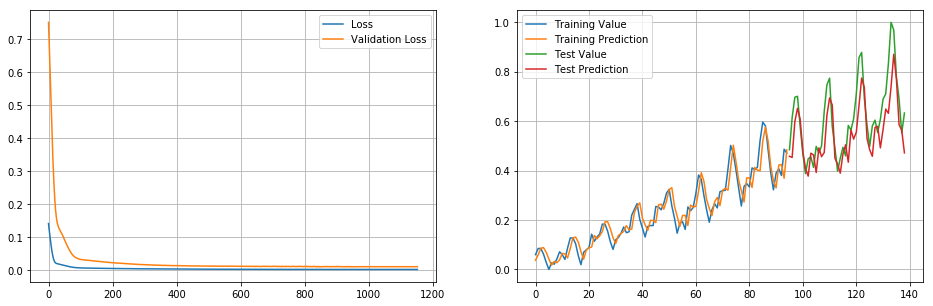

In [42]:
plot_model_results(model)